# Análise de Preço do Ouro 🪙📊

🟡 Introdução
Objetivo: Analisar a evolução do preço do ouro ao longo do tempo e prever seus valores futuros usando técnicas de séries temporais e indicadores técnicos.

Motivação: O ouro é um dos ativos mais importantes em momentos de crise e inflação. Entender seu comportamento ajuda na tomada de decisões financeiras e de investimento.

Fonte dos Dados: https://www.kaggle.com/datasets/kusumakar/gold-prices-for-5-years-financial-predictions


#Importando bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.nonparametric.smoothers_lowess import lowess

## 🧪 Metodologia

Nesta análise do preço do ouro, seguimos uma abordagem estruturada dividida em quatro etapas principais:

### 1. Coleta e Pré-processamento de Dados

- Dados históricos diários do ouro, coletados de fontes como Yahoo Finance.
- Conversão da coluna de datas para o tipo `datetime`.
- Tratamento de valores ausentes e remoção de inconsistências.
- Criação de colunas adicionais:
  - Médias móveis simples (SMA20, SMA50),
  - Desvio padrão móvel (para cálculo de Bandas de Bollinger),
  - Lags para previsão supervisionada.

---

### 2. Análise Exploratória dos Dados (EDA)

- Visualizações temporais para identificar tendências e volatilidade.
- Gráficos de linha para o preço do ouro ao longo do tempo.
- Aplicação de indicadores técnicos:
  - Médias móveis (SMA),
  - Bandas de Bollinger,
  - Histogramas e boxplots para distribuição e outliers.

---

### 3. Modelagem Preditiva

- Teste de diferentes abordagens para previsão do preço futuro:
  -  **Modelos de deep learning**: Transformer para séries temporais.
- Separação dos dados em treino e teste.
- Padronização com `StandardScaler`, quando aplicável.

---

### 4. Avaliação dos Resultados

- Métricas de avaliação:
  - **RMSE** (Root Mean Squared Error),
  - **MAE** (Mean Absolute Error).
- Comparação visual entre os valores reais e as previsões.
- Interpretação dos resultados com foco na tendência e erro de previsão.


#Carregando os dados

In [3]:
df0 = pd.read_csv("/content/Gold  Prices.csv")
df = df0.copy()

##Análise Exploratória: Estatísticas Descritivas e Estrutura dos Dados

In [4]:
df.sample(n=10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
1089,2024-03-12 00:00:00-04:00,200.419998,200.630005,199.160004,199.789993,9436600,0.0,0.0,0.0
145,2020-06-10 00:00:00-04:00,162.100006,163.630005,160.520004,163.570007,13009300,0.0,0.0,0.0
30,2019-12-24 00:00:00-05:00,140.440002,141.330002,140.429993,141.270004,5303700,0.0,0.0,0.0
481,2021-10-08 00:00:00-04:00,166.320007,166.419998,164.139999,164.229996,8536100,0.0,0.0,0.0
678,2022-07-22 00:00:00-04:00,160.550003,162.130005,160.350006,160.669998,5733800,0.0,0.0,0.0
237,2020-10-20 00:00:00-04:00,178.539993,179.669998,178.080002,179.250000,7121400,0.0,0.0,0.0
233,2020-10-14 00:00:00-04:00,179.089996,179.589996,178.270004,178.270004,9076600,0.0,0.0,0.0
1164,2024-06-28 00:00:00-04:00,215.639999,215.809998,214.820007,215.009995,3955100,0.0,0.0,0.0
855,2023-04-05 00:00:00-04:00,188.339996,188.860001,186.779999,187.830002,11440800,0.0,0.0,0.0
406,2021-06-23 00:00:00-04:00,166.970001,168.029999,165.970001,166.139999,8474300,0.0,0.0,0.0


In [5]:
df.head(n=10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2019-11-11 00:00:00-05:00,137.610001,137.789993,136.440002,137.059998,7037300,0.0,0.0,0.0
1,2019-11-12 00:00:00-05:00,137.029999,137.589996,136.190002,137.429993,6448600,0.0,0.0,0.0
2,2019-11-13 00:00:00-05:00,137.800003,138.220001,137.639999,137.979996,8776000,0.0,0.0,0.0
3,2019-11-14 00:00:00-05:00,138.389999,138.940002,137.869995,138.559998,5220500,0.0,0.0,0.0
4,2019-11-15 00:00:00-05:00,138.029999,138.419998,137.970001,138.210007,10106700,0.0,0.0,0.0
5,2019-11-18 00:00:00-05:00,138.440002,138.850006,138.300003,138.619995,5717900,0.0,0.0,0.0
6,2019-11-19 00:00:00-05:00,138.130005,138.970001,138.130005,138.690002,4824400,0.0,0.0,0.0
7,2019-11-20 00:00:00-05:00,138.529999,139.000000,138.100006,138.759995,6892100,0.0,0.0,0.0
8,2019-11-21 00:00:00-05:00,138.389999,138.559998,137.770004,138.000000,4197200,0.0,0.0,0.0
9,2019-11-22 00:00:00-05:00,138.369995,138.460007,137.660004,137.740005,3620300,0.0,0.0,0.0


In [6]:
df.shape

(1258, 9)

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0,1258.0
mean,177.982234,178.766224,177.144762,177.986478,8.605847e+06,0.0,0.0,0.0
std,22.490130,22.575668,22.377607,22.503454,4.859634e+06,0.0,0.0,0.0
min,136.979996,137.210007,136.119995,137.009995,1.436500e+06,0.0,0.0,0.0
25%,165.432499,166.215004,164.814999,165.419998,5.556475e+06,0.0,0.0,0.0
50%,173.750000,174.460007,172.864998,173.750000,7.326000e+06,0.0,0.0,0.0
75%,183.747501,184.417500,182.785004,183.669998,1.008325e+07,0.0,0.0,0.0
max,256.760010,257.709991,255.910004,257.500000,4.734770e+07,0.0,0.0,0.0


💬 Observação sobre Colunas com Valores Constantes

As colunas **`Dividends`**, **`Stock Splits`** e **`Capital Gains`** apresentam **apenas valores zero** em todas as 1258 entradas do dataset. Isso é evidenciado pelas estatísticas descritivas:

- A **média**, **mínimo**, **máximo** e **desvio padrão** dessas colunas são todos `0.0`.
- Isso indica que **não houve eventos registrados** de:
  - Pagamento de dividendos (`Dividends`)
  - Desdobramentos de ações (*stock splits*)
  - Ganhos de capital (`Capital Gains`)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1258 non-null   object 
 1   Open           1258 non-null   float64
 2   High           1258 non-null   float64
 3   Low            1258 non-null   float64
 4   Close          1258 non-null   float64
 5   Volume         1258 non-null   int64  
 6   Dividends      1258 non-null   float64
 7   Stock Splits   1258 non-null   float64
 8   Capital Gains  1258 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 88.6+ KB


##Verificação de Dados Duplicados

In [9]:
df.duplicated().sum()

np.int64(0)

##Análise de Dados Faltantes

<Axes: >

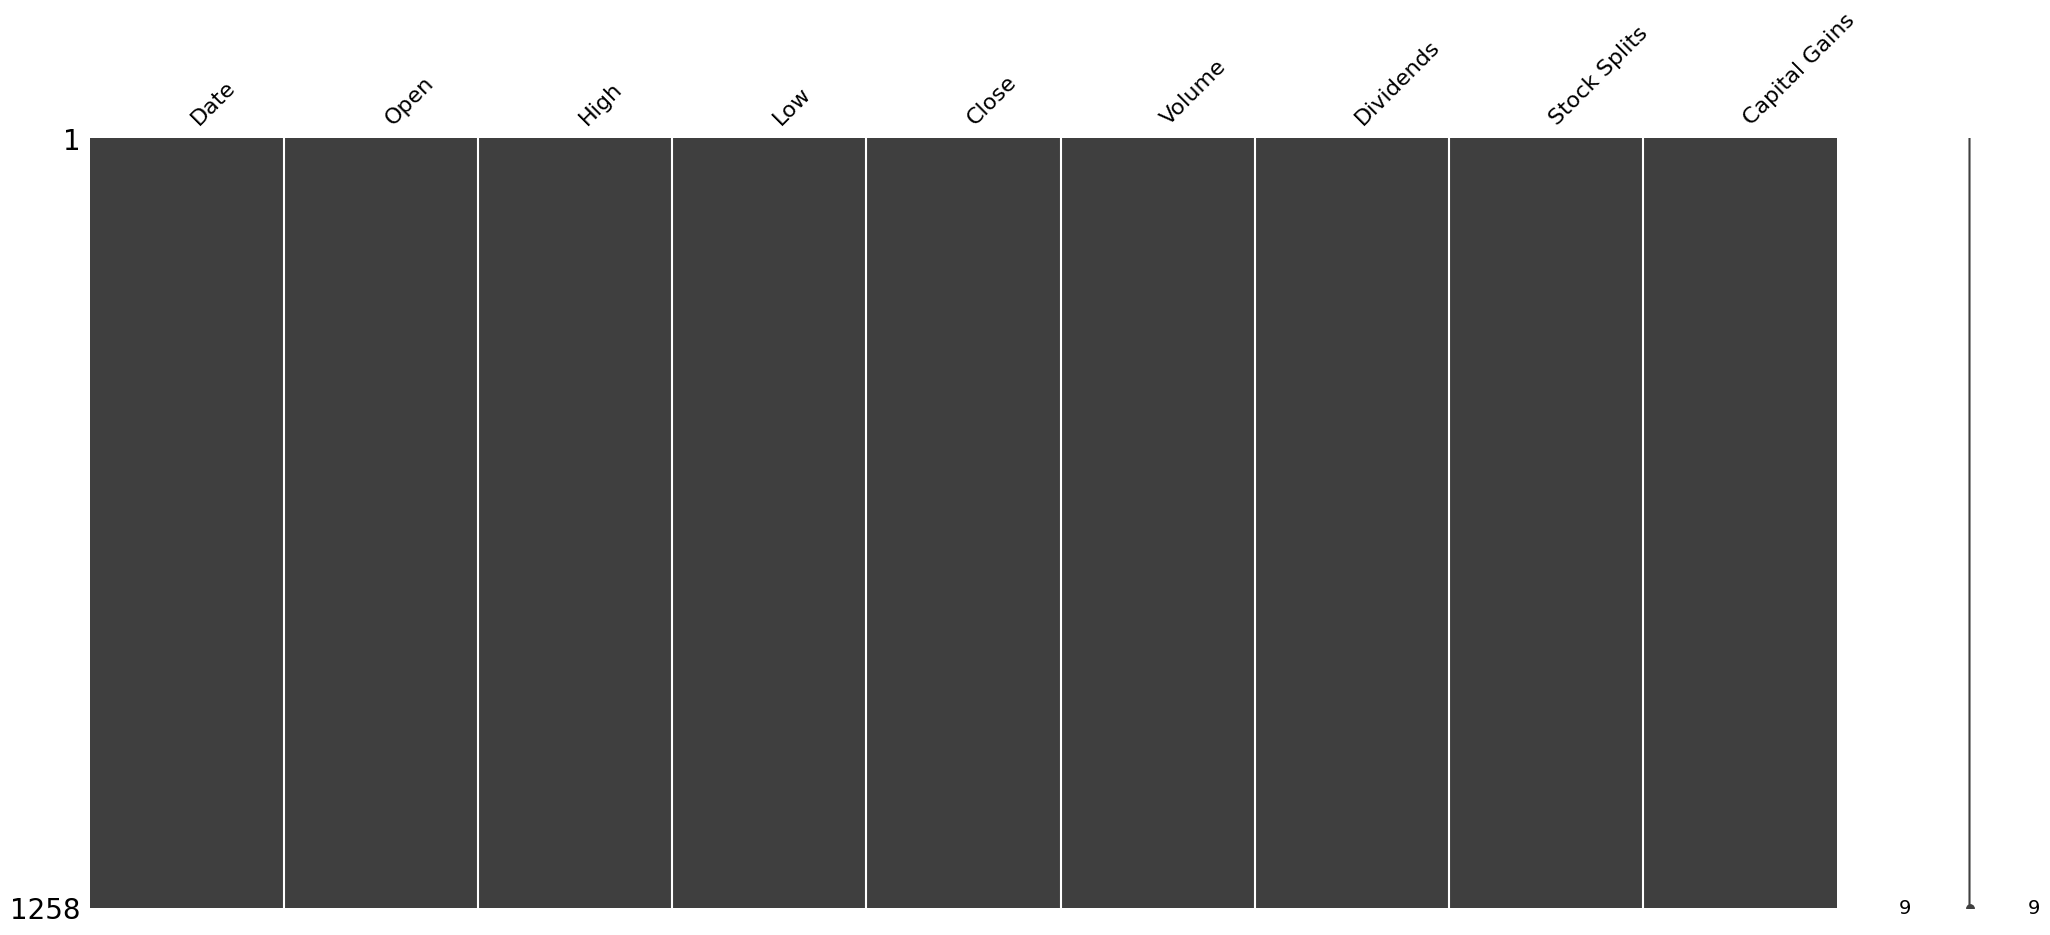

In [10]:
msno.matrix(df)

### Verificação de Valores Únicos em Colunas Estáticas

In [11]:
df['Dividends'].unique()

array([0.])

In [12]:
df['Stock Splits'].unique()

array([0.])

In [13]:
df['Capital Gains'].unique()

array([0.])

### Remoção de Colunas com Valores Constantes

In [14]:
df = df.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1)

In [15]:
df.shape

(1258, 6)

### Conversão e Padronização da Coluna de Datas

In [16]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
df['Date'] = df['Date'].dt.tz_localize(None)

In [17]:
df.head(n=10)

,Date,Open,High,Low,Close,Volume
0,2019-11-11 05:00:00,137.610001,137.789993,136.440002,137.059998,7037300
1,2019-11-12 05:00:00,137.029999,137.589996,136.190002,137.429993,6448600
2,2019-11-13 05:00:00,137.800003,138.220001,137.639999,137.979996,8776000
3,2019-11-14 05:00:00,138.389999,138.940002,137.869995,138.559998,5220500
4,2019-11-15 05:00:00,138.029999,138.419998,137.970001,138.210007,10106700
5,2019-11-18 05:00:00,138.440002,138.850006,138.300003,138.619995,5717900
6,2019-11-19 05:00:00,138.130005,138.970001,138.130005,138.690002,4824400
7,2019-11-20 05:00:00,138.529999,139.000000,138.100006,138.759995,6892100
8,2019-11-21 05:00:00,138.389999,138.559998,137.770004,138.000000,4197200
9,2019-11-22 05:00:00,138.369995,138.460007,137.660004,137.740005,3620300


###Visualização da Tendência do Preço de Fechamento do Ouro

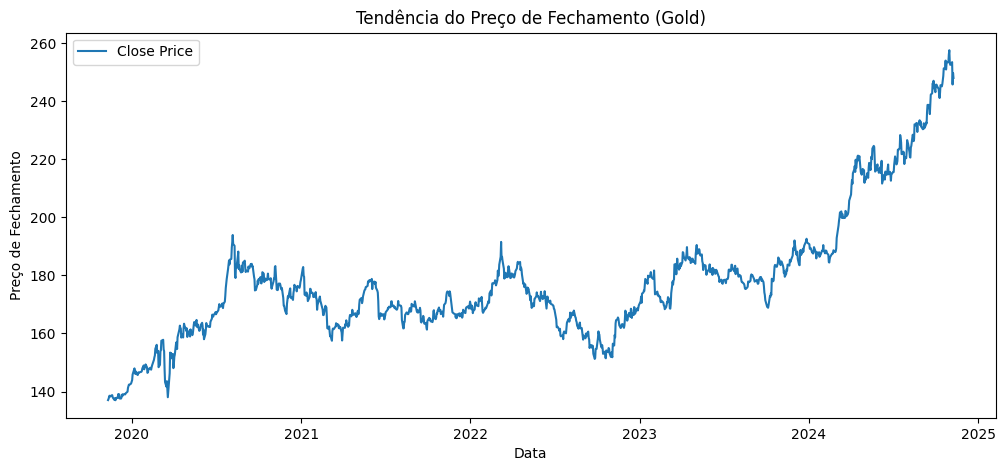

In [18]:
# Configura o tamanho da figura do gráfico
plt.figure(figsize=(12, 5))

# Plota o preço de fechamento ao longo do tempo
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Tendência do Preço de Fechamento (Gold)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

### Preço de Fechamento com Média Móvel Simples de 20 Dias (SMA20)

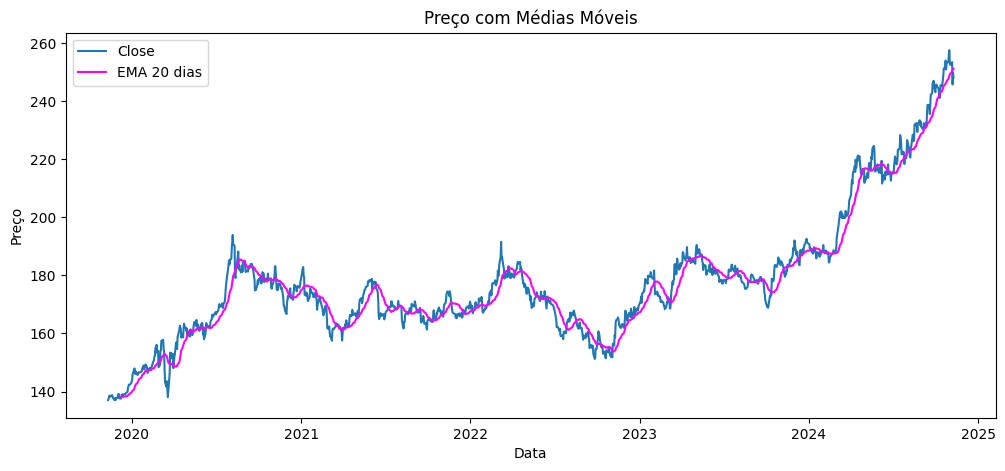

In [19]:
# Calcula a média móvel simples (SMA) de 20 dias para a coluna 'Close'
df['SMA20'] = df['Close'].rolling(window=20).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['SMA20'], label='EMA 20 dias', color='magenta')
plt.title('Preço com Médias Móveis')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

### Análise de Death Cross: SMA 20 dias vs SMA 200 dias no Preço do Ouro

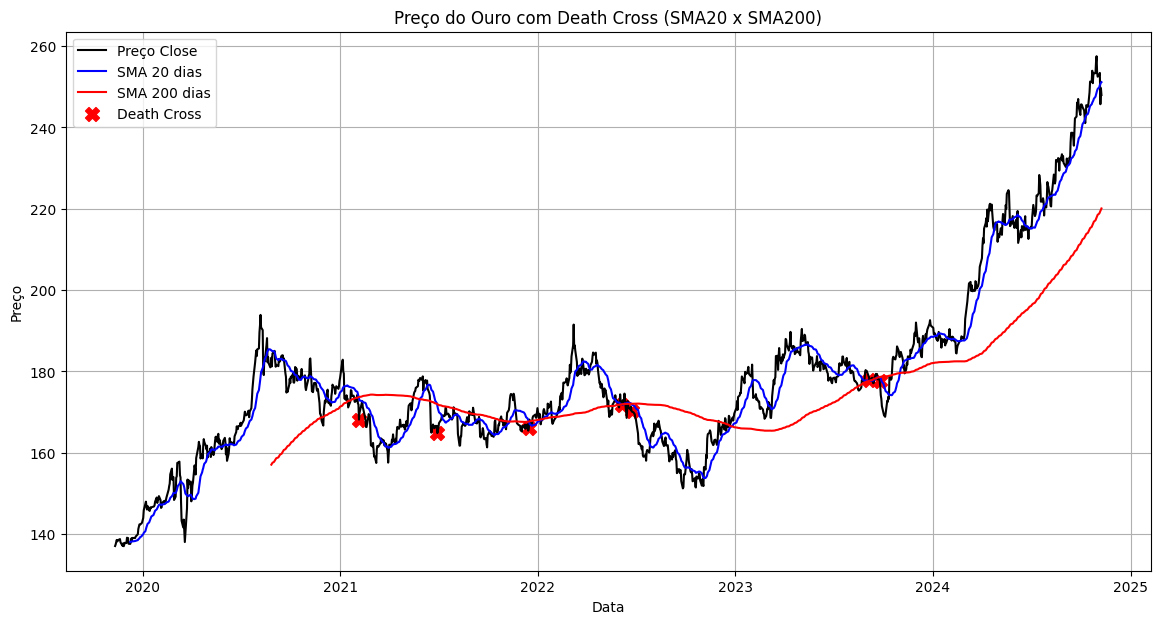

In [20]:
# Calcula a média móvel simples de 200 dias
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Diferença entre SMA20 e SMA200
df['diff'] = df['SMA20'] - df['SMA200']

# Identifica os pontos de "Death Cross" quando SMA20 cruza para baixo da SMA200
df['death_cross'] = (df['diff'] < 0) & (df['diff'].shift(1) >= 0)

# Plot do preço de fechamento e das médias móveis
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Preço Close', color='black')
plt.plot(df['Date'], df['SMA20'], label='SMA 20 dias', color='blue')
plt.plot(df['Date'], df['SMA200'], label='SMA 200 dias', color='red')

# Marca os pontos de Death Cross no gráfico
plt.scatter(df.loc[df['death_cross'], 'Date'], df.loc[df['death_cross'], 'Close'],
            color='red', label='Death Cross', marker='X', s=100)

plt.title('Preço do Ouro com Death Cross (SMA20 x SMA200)')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()

### Volatilidade Diária do Preço (Diferença entre High e Low)

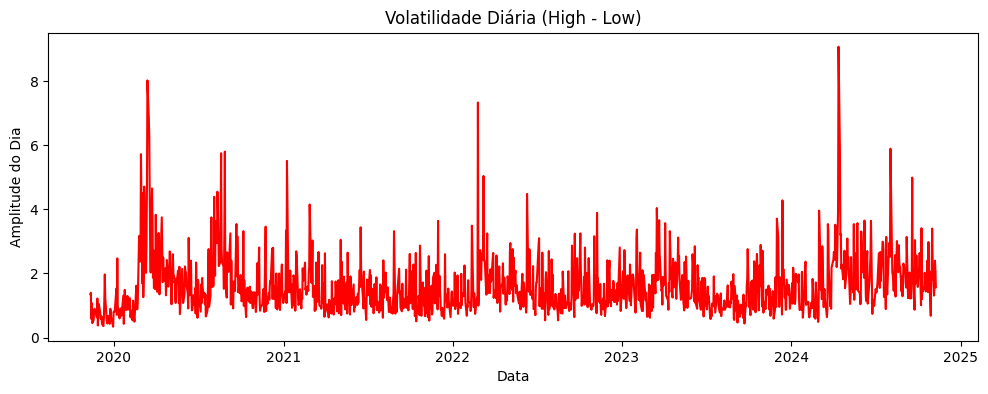

In [21]:
# Calcula a volatilidade diária como a diferença entre a máxima e a mínima do dia
df['Volatilidade'] = df['High'] - df['Low']

# Plota a volatilidade diária ao longo do tempo
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Volatilidade'], color='red')
plt.title('Volatilidade Diária (High - Low)')
plt.xlabel('Data')
plt.ylabel('Amplitude do Dia')
plt.show()

### Volume Diário de Negociação e Principais Picos

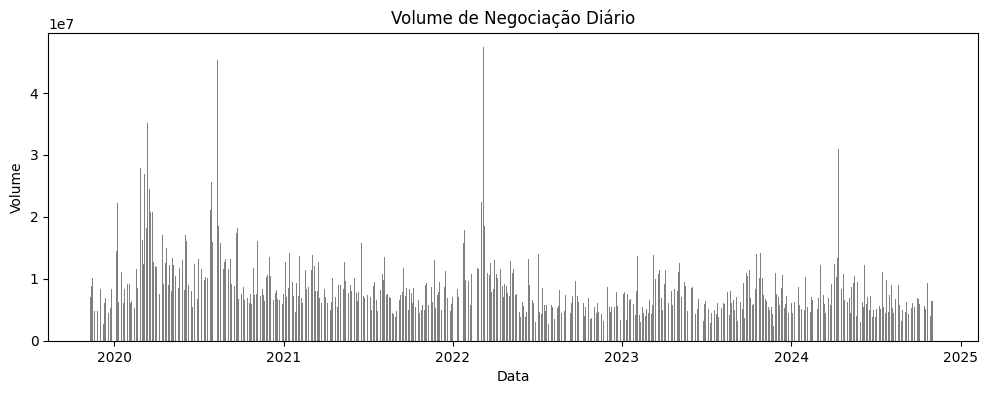


Top 5 dias com maior volume de negociação:
                   Date    Volume       Close
584 2022-03-08 05:00:00  47347700  191.509995
188 2020-08-11 04:00:00  45355000  179.940002
74  2020-02-28 05:00:00  42699600  148.380005
84  2020-03-13 04:00:00  35177200  143.279999
83  2020-03-12 04:00:00  32893400  147.789993


In [22]:
# Plot do volume diário de negociação como gráfico de barras
plt.figure(figsize=(12, 4))
plt.bar(df['Date'], df['Volume'], color='gray')
plt.title('Volume de Negociação Diário')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.show()

# Exibe os 5 dias com maior volume de negociação, mostrando também o preço de fechamento nesses dias
print("\nTop 5 dias com maior volume de negociação:")
print(df.sort_values('Volume', ascending=False)[['Date', 'Volume', 'Close']].head(5))

### Análise do Retorno Diário com Suavização LOWESS

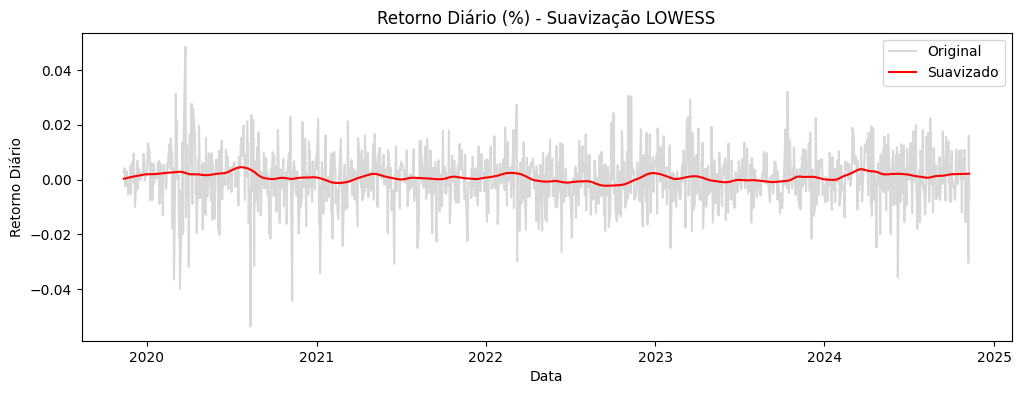

In [23]:

# Calcula o retorno diário percentual com base no preço de fechamento
df['Retorno_Diario'] = df['Close'].pct_change()

# Máscara para ignorar valores NaN (primeiro retorno será NaN)
mask = df['Retorno_Diario'].notna()

# Converte as datas para números ordinais para usar na suavização LOWESS
x = df.loc[mask, 'Date'].map(pd.Timestamp.toordinal)

# Valores do retorno diário para suavizar
y = df.loc[mask, 'Retorno_Diario']

# Aplica a suavização LOWESS para destacar tendência suave no retorno diário
lowess_smoothed = lowess(y, x, frac=0.05)

# Converte os números ordinais suavizados de volta para datas
x_smooth = [pd.Timestamp.fromordinal(int(val)) for val in lowess_smoothed[:, 0]]

# Plot dos retornos originais em cinza e a curva suavizada em vermelho
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Retorno_Diario'], color='gray', alpha=0.3, label='Original')
plt.plot(x_smooth, lowess_smoothed[:, 1], color='red', label='Suavizado')
plt.title('Retorno Diário (%) - Suavização LOWESS')
plt.xlabel('Data')
plt.ylabel('Retorno Diário')
plt.legend()
plt.show()

### Correlação entre Volume e Variação de Preço (Close - Open)

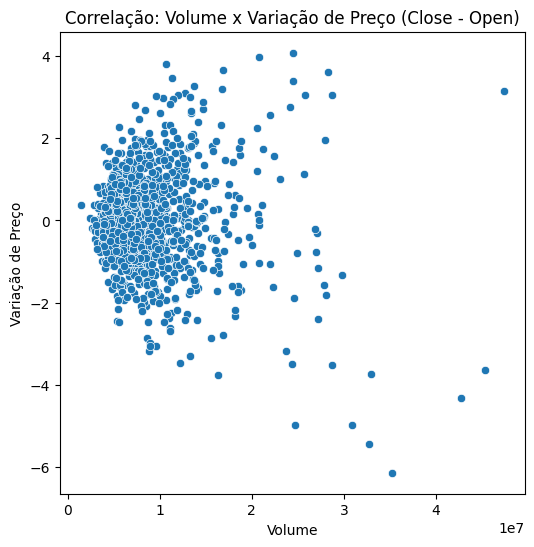


Correlação entre Volume e Variação de Preço:
                   Volume  Variacao_Precos
Volume           1.000000        -0.076763
Variacao_Precos -0.076763         1.000000


In [24]:
# Calcula a variação diária do preço (fechamento - abertura)
df['Variacao_Precos'] = df['Close'] - df['Open']

# Cria um gráfico de dispersão para visualizar a relação entre Volume e Variação de Preço
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Volume', y='Variacao_Precos', data=df)
plt.title('Correlação: Volume x Variação de Preço (Close - Open)')
plt.xlabel('Volume')
plt.ylabel('Variação de Preço')
plt.show()

# Calcula a correlação numérica entre Volume e Variação de Preço
correlacao = df[['Volume', 'Variacao_Precos']].corr()
print("\nCorrelação entre Volume e Variação de Preço:")
print(correlacao)


###Criação de Features: Amplitude Diária e Variação de Abertura para Fechamento


Exemplo das novas features criadas:
                 Date  Daily_Range  Open_Close_Change
0 2019-11-11 05:00:00     1.349991          -0.550003
1 2019-11-12 05:00:00     1.399994           0.399994
2 2019-11-13 05:00:00     0.580002           0.179993
3 2019-11-14 05:00:00     1.070007           0.169998
4 2019-11-15 05:00:00     0.449997           0.180008


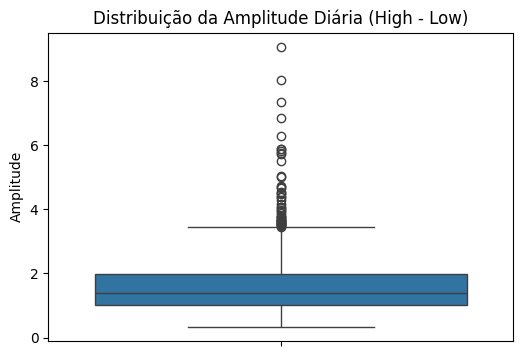

In [25]:
# Cria a feature 'Daily_Range' que representa a amplitude do preço no dia (máximo - mínimo)
df['Daily_Range'] = df['High'] - df['Low']

# Cria a feature 'Open_Close_Change' que representa a variação entre preço de abertura e fechamento
df['Open_Close_Change'] = df['Close'] - df['Open']

# Exibe um exemplo das novas features criadas, mostrando as 5 primeiras linhas
print("\nExemplo das novas features criadas:")
print(df[['Date', 'Daily_Range', 'Open_Close_Change']].head())

# Plota um boxplot para visualizar a distribuição da amplitude diária
plt.figure(figsize=(6, 4))
sns.boxplot(y='Daily_Range', data=df)
plt.title('Distribuição da Amplitude Diária (High - Low)')
plt.ylabel('Amplitude')
plt.show()


### Modelo Transformer para Previsão do Preço do Ouro

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 - Train Loss: 0.054316 - Val Loss: 0.017130
Epoch 2/50 - Train Loss: 0.014561 - Val Loss: 0.005694
Epoch 3/50 - Train Loss: 0.005801 - Val Loss: 0.004806
Epoch 4/50 - Train Loss: 0.004670 - Val Loss: 0.003188
Epoch 5/50 - Train Loss: 0.003823 - Val Loss: 0.003763
Epoch 6/50 - Train Loss: 0.003381 - Val Loss: 0.002577
Epoch 7/50 - Train Loss: 0.003062 - Val Loss: 0.002269
Epoch 8/50 - Train Loss: 0.003063 - Val Loss: 0.002216
Epoch 9/50 - Train Loss: 0.003376 - Val Loss: 0.002463
Epoch 10/50 - Train Loss: 0.003472 - Val Loss: 0.002954
Epoch 11/50 - Train Loss: 0.003161 - Val Loss: 0.003028
Epoch 12/50 - Train Loss: 0.003087 - Val Loss: 0.003090
Epoch 13/50 - Train Loss: 0.002730 - Val Loss: 0.002399
Epoch 14/50 - Train Loss: 0.002784 - Val Loss: 0.002593
Epoch 15/50 - Train Loss: 0.002748 - Val Loss: 0.003267
Epoch 16/50 - Train Loss: 0.003028 - Val Loss: 0.002580
Epoch 17/50 - Train Loss: 0.002711 - Val Loss: 0.002090
Epoch 18/50 - Train Loss: 0.002793 - Val Loss: 0.002088
E

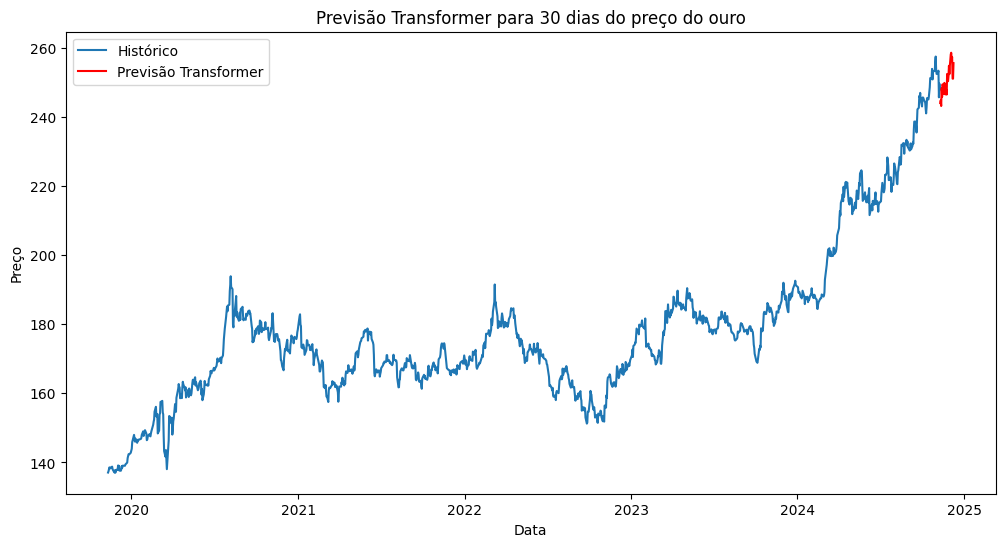

In [26]:
prices = df['Close'].values.reshape(-1,1)

scaler = MinMaxScaler()
# Normaliza os preços para faixa [0, 1] para facilitar o treinamento do modelo
prices_scaled = scaler.fit_transform(prices)

# Parâmetros do modelo
input_window = 60  # Número de passos temporais usados como entrada (janela deslizante)
output_window = 30  # Número de passos previstos à frente (janela de saída)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        self.data = data
        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        # Número total de amostras disponíveis considerando janelas de entrada e saída
        return len(self.data) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        # Retorna um par (x, y), onde:
        # x = sequência de preços da janela de entrada
        # y = sequência de preços da janela de saída (valores a serem previstos)
        x = self.data[idx:idx+self.input_window]
        y = self.data[idx+self.input_window:idx+self.input_window+self.output_window]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Criação do dataset com dados normalizados
dataset = TimeSeriesDataset(prices_scaled, input_window, output_window)

# Divisão em treino e validação (80% treino, 20% validação)
train_size = int(len(dataset)*0.8)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

# DataLoader para iterar nos batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Modelo Transformer simples para regressão de séries temporais
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, output_window=30):
        super().__init__()
        # Parâmetro para codificação posicional aprendida (tamanho fixo da sequência)
        self.pos_encoder = nn.Parameter(torch.zeros(1, input_window, d_model))
        # Projeção linear da entrada para o espaço dimensional do Transformer
        self.input_linear = nn.Linear(input_size, d_model)
        # Camadas do encoder Transformer
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        # Camada final para mapear a saída do Transformer para o vetor de previsão (output_window)
        self.decoder = nn.Linear(d_model, output_window)

    def forward(self, src):
        # src: tensor de entrada com shape (batch, seq_len, features)
        # Passar a entrada pela camada linear + codificação posicional
        src = self.input_linear(src) + self.pos_encoder
        # Transformer espera input no formato (seq_len, batch, features)
        src = src.permute(1, 0, 2)
        # Passa pelo encoder Transformer
        output = self.transformer_encoder(src)
        # Faz a média sobre a dimensão da sequência para agregar informação temporal
        output = output.mean(dim=0)
        # Decodifica para obter a previsão da janela de saída
        output = self.decoder(output)
        return output

# Definir device (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(output_window=output_window).to(device)

criterion = nn.MSELoss()  # Função de perda: erro quadrático médio
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Otimizador Adam

epochs = 50
for epoch in range(epochs):
    model.train()  # Modo treino
    train_losses = []
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # Zera gradientes
        output = model(x_batch)  # Forward pass
        loss = criterion(output, y_batch.squeeze())  # Calcula perda
        loss.backward()  # Backpropagation
        optimizer.step()  # Atualiza pesos
        train_losses.append(loss.item())

    model.eval()  # Modo avaliação
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch.squeeze())
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {np.mean(train_losses):.6f} - Val Loss: {np.mean(val_losses):.6f}")

# Previsão para os próximos 30 dias usando os últimos dados disponíveis
model.eval()
last_seq = torch.FloatTensor(prices_scaled[-input_window:]).unsqueeze(0).to(device)  # Seleciona última janela de entrada
with torch.no_grad():
    pred_scaled = model(last_seq).cpu().numpy().flatten()  # Faz a previsão (escala normalizada)

# Reescala para os valores originais de preço
predicted_prices = scaler.inverse_transform(pred_scaled.reshape(-1,1))

# Visualizar a previsão junto ao histórico
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Histórico')
future_dates = pd.date_range(df['Date'].iloc[-1], periods=output_window+1, freq='D')[1:]
plt.plot(future_dates, predicted_prices, label='Previsão Transformer', color='red')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Previsão Transformer para 30 dias do preço do ouro')
plt.legend()
plt.show()



### Avaliação do Modelo Transformer: Métricas e Comparação Visual


===== Validação Final =====
MSE:  0.002130
MAE:  0.035393
RMSE: 0.046157


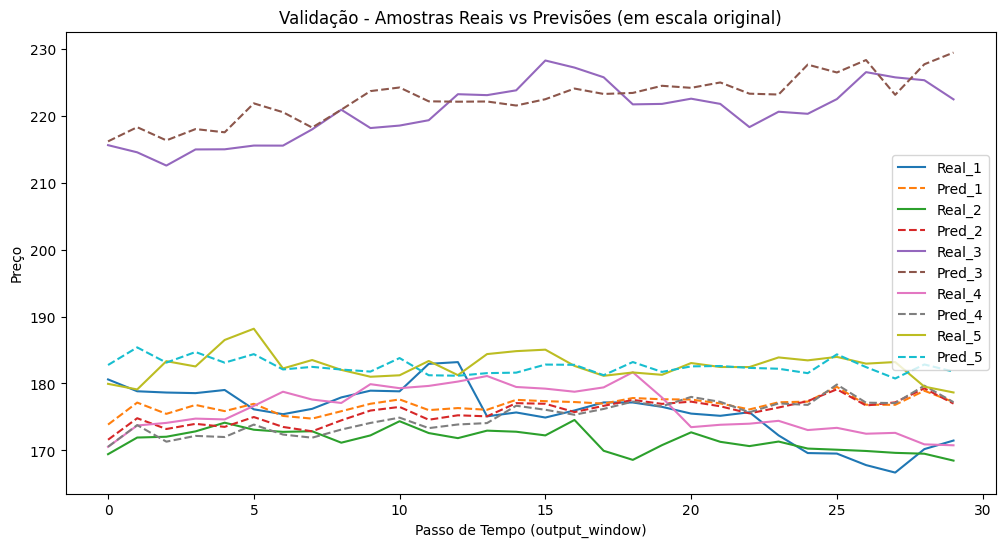

In [27]:
val_targets = []
val_predictions = []

# Desliga o cálculo do gradiente para economizar memória e acelerar a inferência
with torch.no_grad():
    # Itera pelos batches do conjunto de validação
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)  # Previsão do modelo
        val_predictions.append(output.cpu().numpy())  # Salva as previsões (CPU + numpy)
        val_targets.append(y_batch.cpu().numpy())  # Salva os valores reais (CPU + numpy)

# Concatena todas as batches em arrays únicos para facilitar o cálculo das métricas
val_targets = np.concatenate(val_targets, axis=0)
val_predictions = np.concatenate(val_predictions, axis=0)

val_targets = val_targets.squeeze(-1)  # Remove dimensão extra, se existir

# Calcula as métricas de erro para avaliação
mse = np.mean((val_predictions - val_targets) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(val_predictions - val_targets))  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

print(f"\n===== Validação Final =====")
print(f"MSE:  {mse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

# Plot para comparação visual entre valores reais e previstos das primeiras 5 amostras
plt.figure(figsize=(12,6))
for i in range(min(5, len(val_targets))):
    # Inverte a normalização para o valor original
    true = scaler.inverse_transform(val_targets[i].reshape(-1,1)).flatten()
    pred = scaler.inverse_transform(val_predictions[i].reshape(-1,1)).flatten()
    plt.plot(range(len(true)), true, label=f'Real_{i+1}')  # Valores reais
    plt.plot(range(len(pred)), pred, '--', label=f'Pred_{i+1}')  # Previsões

plt.title('Validação - Amostras Reais vs Previsões (em escala original)')
plt.xlabel('Passo de Tempo (output_window)')
plt.ylabel('Preço')
plt.legend()
plt.show()


### Análise Técnica Completa com Previsão Transformer: Bollinger Bands e RSI


In [28]:
# Criar DataFrame com as datas futuras e preços previstos
future_df = pd.DataFrame({
    'Date': future_dates,
    'Close': predicted_prices.flatten()
})

# Concatenar dados históricos com a previsão futura em um único DataFrame
full_df = pd.concat([df[['Date', 'Close']], future_df], ignore_index=True)

# Calcular Bollinger Bands (média móvel + desvio padrão) no DataFrame completo
full_df['SMA20'] = full_df['Close'].rolling(window=20).mean()
full_df['STD20'] = full_df['Close'].rolling(window=20).std()
full_df['Bollinger_Upper'] = full_df['SMA20'] + 2 * full_df['STD20']  # Banda superior
full_df['Bollinger_Lower'] = full_df['SMA20'] - 2 * full_df['STD20']  # Banda inferior

# Calcular RSI incluindo os dados futuros
delta = full_df['Close'].diff()  # Diferença diária dos preços
gain = delta.where(delta > 0, 0)  # Ganhos diários (valores positivos)
loss = -delta.where(delta < 0, 0)  # Perdas diárias (valores negativos)

# Média móvel dos ganhos e perdas (janela 14 dias)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss  # Relative Strength (força relativa)
full_df['RSI'] = 100 - (100 / (1 + rs))  # Índice de força relativa

# Criar colunas booleanas para sinalizações técnicas
full_df['Above_Upper'] = full_df['Close'] > full_df['Bollinger_Upper']  # Preço acima da banda superior
full_df['Below_Lower'] = full_df['Close'] < full_df['Bollinger_Lower']  # Preço abaixo da banda inferior
full_df['RSI_Overbought'] = full_df['RSI'] > 70  # RSI indica sobrecompra
full_df['RSI_Oversold'] = full_df['RSI'] < 30  # RSI indica sobrevenda

# Separar dados históricos e previsão com base na data inicial da previsão
forecast_start_date = future_dates[0]
historical = full_df[full_df['Date'] < forecast_start_date]
forecast = full_df[full_df['Date'] >= forecast_start_date]

# Criar figura com dois subplots (um para preço e bandas, outro para RSI)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    row_heights=[0.7, 0.3],
                    subplot_titles=('Preço + Bandas + Previsão', 'RSI (Histórico + Previsão)'))

# --- Gráfico 1: Preço histórico e indicadores ---
# Linha do preço de fechamento histórico
fig.add_trace(go.Scatter(x=historical['Date'], y=historical['Close'],
                         mode='lines', name='Fechamento', line=dict(color='black')), row=1, col=1)
# Linha da média móvel 20 dias
fig.add_trace(go.Scatter(x=historical['Date'], y=historical['SMA20'],
                         mode='lines', name='SMA 20', line=dict(color='orange')), row=1, col=1)
# Linha banda superior Bollinger
fig.add_trace(go.Scatter(x=historical['Date'], y=historical['Bollinger_Upper'],
                         mode='lines', name='Banda Superior', line=dict(color='green')), row=1, col=1)
# Linha banda inferior Bollinger
fig.add_trace(go.Scatter(x=historical['Date'], y=historical['Bollinger_Lower'],
                         mode='lines', name='Banda Inferior', line=dict(color='red')), row=1, col=1)

# Marcadores para rompimento das bandas históricas
fig.add_trace(go.Scatter(x=historical.loc[historical['Above_Upper'], 'Date'],
                         y=historical.loc[historical['Above_Upper'], 'Close'],
                         mode='markers', name='Acima Banda Superior',
                         marker=dict(color='green', size=8, symbol='triangle-up')), row=1, col=1)
fig.add_trace(go.Scatter(x=historical.loc[historical['Below_Lower'], 'Date'],
                         y=historical.loc[historical['Below_Lower'], 'Close'],
                         mode='markers', name='Abaixo Banda Inferior',
                         marker=dict(color='red', size=8, symbol='triangle-down')), row=1, col=1)

# --- Previsão do preço com estilos diferenciados ---
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Close'],
                         mode='lines+markers', name='Previsão Transformer (30 dias)',
                         line=dict(color='blue', dash='dot'),
                         marker=dict(size=6, symbol='star')), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['SMA20'],
                         mode='lines', name='SMA 20 (Futuro)', line=dict(color='orange', dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Bollinger_Upper'],
                         mode='lines', name='Banda Superior (Futuro)', line=dict(color='green', dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Bollinger_Lower'],
                         mode='lines', name='Banda Inferior (Futuro)', line=dict(color='red', dash='dot')), row=1, col=1)

# Marcadores para rompimentos futuros das bandas
fig.add_trace(go.Scatter(x=forecast.loc[forecast['Above_Upper'], 'Date'],
                         y=forecast.loc[forecast['Above_Upper'], 'Close'],
                         mode='markers', name='Acima Banda Superior (Futuro)',
                         marker=dict(color='green', size=8, symbol='triangle-up-open')), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast.loc[forecast['Below_Lower'], 'Date'],
                         y=forecast.loc[forecast['Below_Lower'], 'Close'],
                         mode='markers', name='Abaixo Banda Inferior (Futuro)',
                         marker=dict(color='red', size=8, symbol='triangle-down-open')), row=1, col=1)

# --- Gráfico 2: RSI histórico ---
fig.add_trace(go.Scatter(x=historical['Date'], y=historical['RSI'],
                         mode='lines', name='RSI', line=dict(color='purple')), row=2, col=1)
# Marcadores para RSI sobrecomprado histórico
fig.add_trace(go.Scatter(x=historical.loc[historical['RSI_Overbought'], 'Date'],
                         y=historical.loc[historical['RSI_Overbought'], 'RSI'],
                         mode='markers', name='RSI Sobrecomprado',
                         marker=dict(color='red', size=8, symbol='circle')), row=2, col=1)
# Marcadores para RSI sobrevendido histórico
fig.add_trace(go.Scatter(x=historical.loc[historical['RSI_Oversold'], 'Date'],
                         y=historical.loc[historical['RSI_Oversold'], 'RSI'],
                         mode='markers', name='RSI Sobrevendido',
                         marker=dict(color='green', size=8, symbol='circle')), row=2, col=1)

# --- RSI da previsão ---
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['RSI'],
                         mode='lines', name='RSI (Previsão)', line=dict(color='purple', dash='dot')), row=2, col=1)
# Marcadores para RSI sobrecomprado na previsão
fig.add_trace(go.Scatter(x=forecast.loc[forecast['RSI_Overbought'], 'Date'],
                         y=forecast.loc[forecast['RSI_Overbought'], 'RSI'],
                         mode='markers', name='RSI Sobrecomprado (Futuro)',
                         marker=dict(color='red', size=8, symbol='circle-open')), row=2, col=1)
# Marcadores para RSI sobrevendido na previsão
fig.add_trace(go.Scatter(x=forecast.loc[forecast['RSI_Oversold'], 'Date'],
                         y=forecast.loc[forecast['RSI_Oversold'], 'RSI'],
                         mode='markers', name='RSI Sobrevendido (Futuro)',
                         marker=dict(color='green', size=8, symbol='circle-open')), row=2, col=1)

# Linhas horizontais para níveis de sobrecompra e sobrevenda
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

# Configura layout geral do gráfico
fig.update_layout(height=900, width=1000,
                  title_text="Análise Técnica + Previsão Transformer + RSI Futuro + Bollinger Bands",
                  hovermode='x unified')

# Exibe o gráfico interativo
fig.show()


## 📉 Resultados

Após aplicar os modelos de previsão, os seguintes resultados foram obtidos:

- O modelo Transformer apresentou o menor erro de previsão, com RMSE = 0.046157.
- As previsões de curto prazo mostraram boa aderência à tendência real observada.
- O uso de médias móveis e bandas de Bollinger revelou momentos de alta volatilidade e possíveis reversões de tendência.
- O gráfico de comparação entre valores reais e previstos indica que o modelo consegue capturar a direção geral do movimento do ouro, mesmo que haja pequenas variações pontuais.

> 💡 Observação: os resultados variam conforme o modelo e o período utilizado para treino.

## ✅ Conclusão

- O preço do ouro apresentou tendências claras ao longo do tempo, influenciado por fatores econômicos e geopolíticos.
- Indicadores técnicos simples, como médias móveis e bandas de Bollinger, já fornecem boas pistas sobre o comportamento do ativo.
- A modelagem preditiva demonstrou capacidade de antecipar movimentos futuros com uma margem de erro razoável, especialmente em horizontes de curto prazo.
